## Importing reqired libraries

In [ ]:
# analysis
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("tab10")

#regular expression
import re

#stats modules
import statsmodels.api as sma
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Prophet
from prophet import Prophet

# Evaluation metrics
from sklearn.metrics import (mean_absolute_error as mae,
                             mean_squared_error as mse,
                             mean_absolute_percentage_error as mape)


import warnings
warnings.filterwarnings("ignore")


plt.rcParams['figure.figsize']=(10,8)

In [ ]:
df=pd.read_csv('train_1.csv')
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

## Understanding null values

In [ ]:
(df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100

7.747971020488964

The dataframe has almost 8% null values.



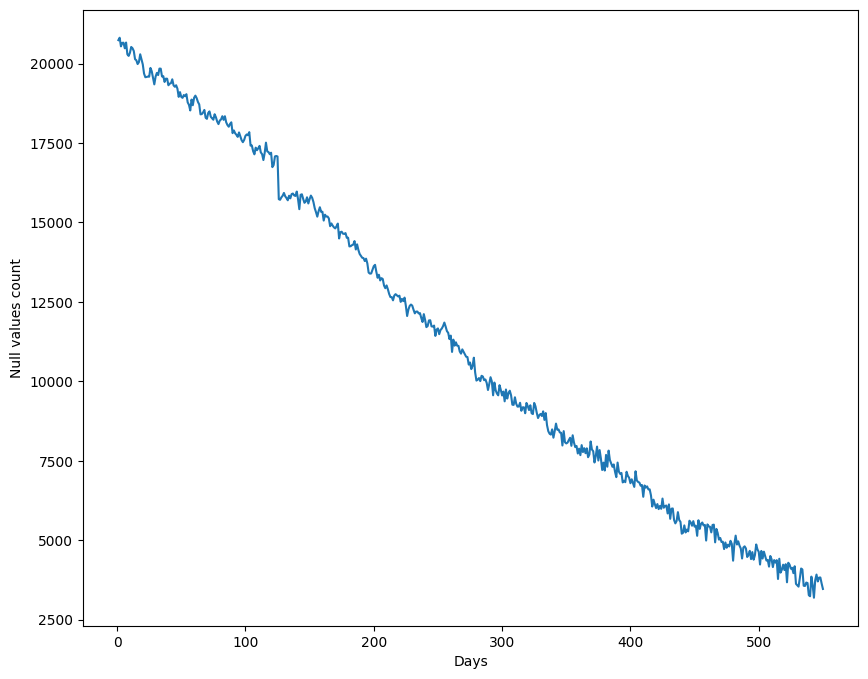

In [ ]:
#storing the count of null values
null_count=[df[cols].isna().sum() for cols in df.columns[1:]]
x=np.arange(1,551)

#plotting null values
plt.plot(x,null_count)
plt.xlabel('Days')
plt.ylabel('Null values count')
plt.show()

**Comments:**

1. We can see that the number of null values decreases as the days progress.
2. This is because a few websites may not have existed earlier and started on the later part of the time series.

**Rows with more null values:**

In [ ]:
#creating mask and filtering
mask=df.isnull().sum(axis=1)>300
null_row_index=df[mask].index

#dropping the rows with more null values
df.drop(index=null_row_index,inplace=True)

In [ ]:
(df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100

2.80035726982008

After dropping the rows with majority null values, the overall null values dropped to 3%

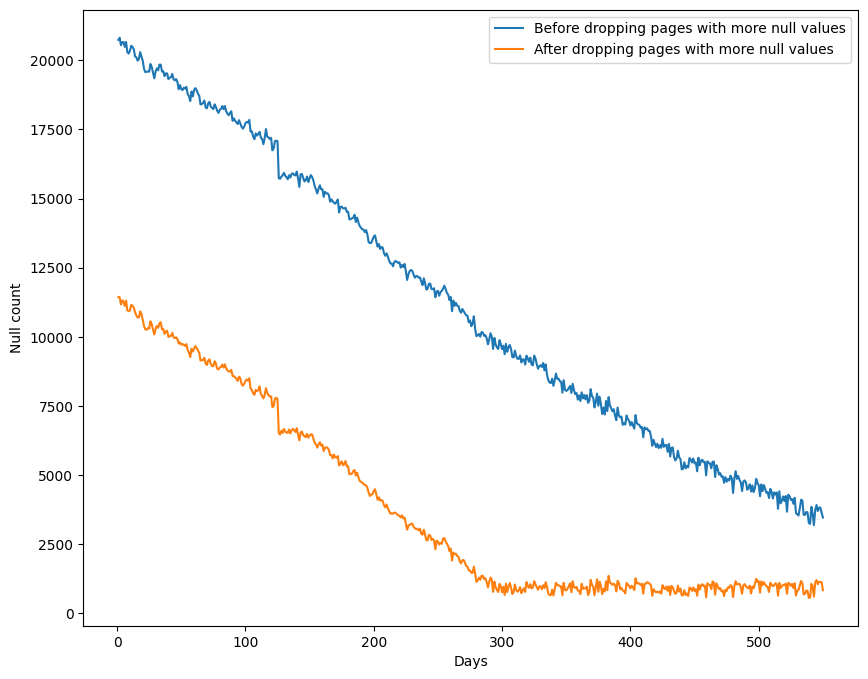

In [ ]:
null_count_ad=[df[cols].isnull().sum() for cols in df.columns[1:]]
days=np.arange(1,551)

plt.plot(days,null_count,label='Before dropping pages with more null values')
plt.plot(days,null_count_ad,label='After dropping pages with more null values')
plt.xlabel('Days')
plt.ylabel('Null count')
plt.legend()
plt.show()

## Data Formatting

**Extracting access type and access origin:**

In [ ]:
def pick_first(data):
    return data[0]

In [ ]:
df['Access_type']=df['Page'].str.findall(r'all-access|desktop|mobile-web').apply(pick_first)

In [ ]:
df['Access_origin']=df['Page'].str.findall(r'all-agents|spider').apply(pick_first)

**Extracting Languages:**

In [ ]:
def pick_lang(data):
    return (str(data[0][0:2]))

In [ ]:
df['Language']=df['Page'].str.findall(r'...wiki').apply(pick_lang)

In [ ]:
def decode_language(data):
    if data=='zh':
        return 'Chinese'
    if data=='fr':
        return 'French'
    if data=='en':
        return 'English'
    if data=='ja':
        return 'Japanese'
    if data=='ru':
        return 'Russian'
    if data=='de':
        return 'German'
    if data=='es':
        return 'Spanish'
    else:
        return 'Unknown'

In [ ]:
df['Language']=df['Language'].apply(decode_language)

## Performing EDA

Shape of the dataset:

In [ ]:
print('No. of rows:',df.shape[0])
print('No. of columns:',df.shape[1])

No. of rows: 135482
No. of columns: 554


We have included 3 new columns 'Access_type', 'Access_region' and 'Language'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135482 entries, 0 to 145022
Columns: 554 entries, Page to Language
dtypes: float64(550), object(4)
memory usage: 573.7+ MB


**Distribution of Access Type**

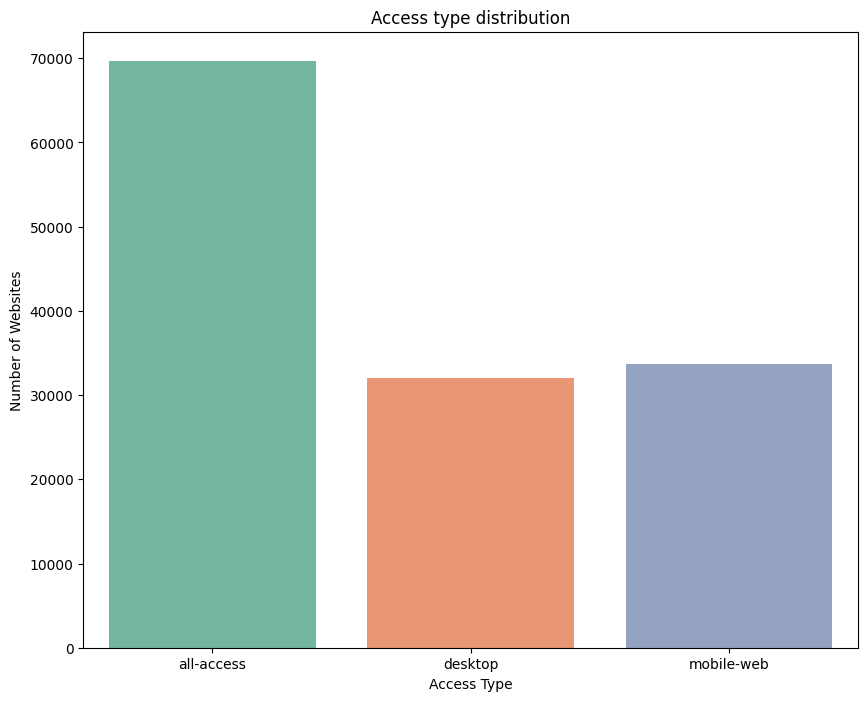

In [ ]:
sns.countplot(x=df['Access_type'],data=df,palette='Set2')
plt.xlabel('Access Type')
plt.ylabel('Number of Websites')
plt.title('Access type distribution')
plt.show()

**OBSERVATIONS:**


*   Desktop and mobile-web are almost equal
*   All-access is double the time of both desktop and mobile-web



**Distribution of Access Origin**

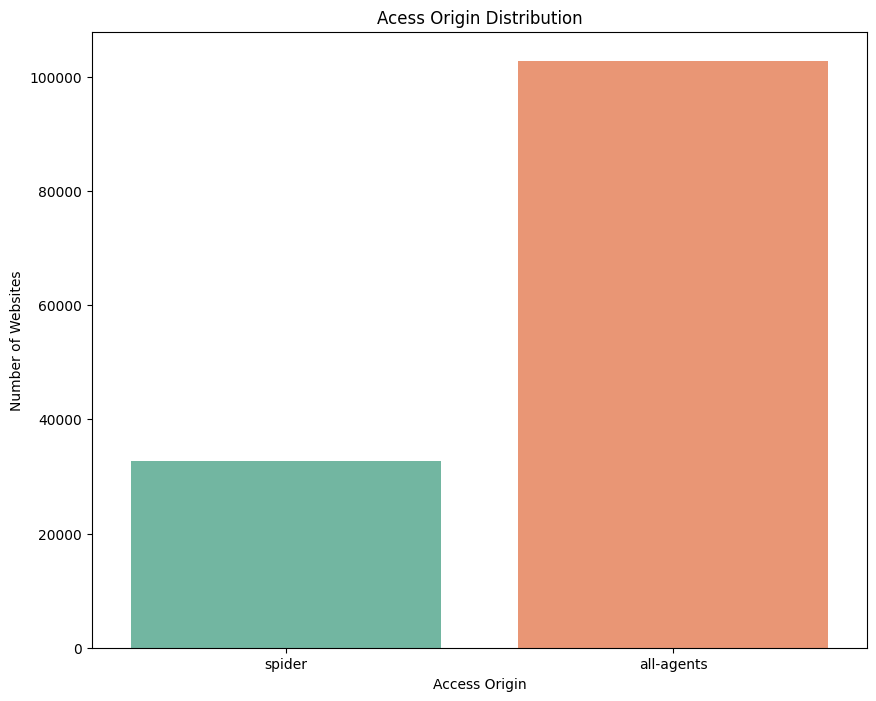

In [ ]:
sns.countplot(x=df['Access_origin'],data=df,palette='Set2')
plt.title('Acess Origin Distribution')
plt.xlabel('Access Origin')
plt.ylabel('Number of Websites')
plt.show()

**Distribution Language**

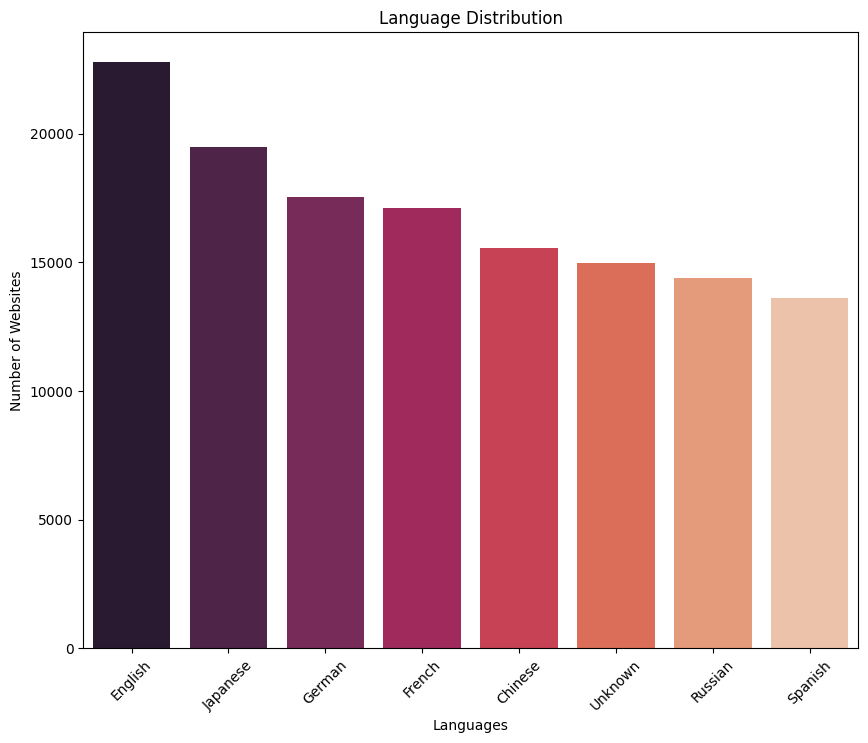

In [ ]:
sns.barplot(x=df.groupby('Language')['Page'].count().sort_values(ascending=False).index,
            y=df.groupby('Language')['Page'].count().sort_values(ascending=False).values,
            palette='rocket')
plt.title('Language Distribution')
plt.xlabel('Languages')
plt.ylabel('Number of Websites')
plt.xticks(rotation=45)
plt.show()

**Observations:**


*   Maximum number of web pages are in English and the second maximum is Japanese.



## Transforming for Time Series Analysis

In [ ]:
agg_df=df.drop(columns=['Page','Access_type','Access_origin']).groupby('Language').mean().reset_index().T.reset_index()

In [ ]:
agg_df.columns=['Date','Chinese','English','French','German','Japanese','Russian','Spanish','Unknown']

In [ ]:
agg_df.drop(index=0,inplace=True)

In [ ]:
agg_df["Date"]=pd.to_datetime(agg_df['Date'])

In [ ]:
agg_df.set_index('Date',inplace=True)

In [ ]:
agg_df.drop(columns=['Unknown'],inplace=True)

In [ ]:
agg_df.head()

Chinese      English      French      German    Japanese  \
Date                                                                      
2015-07-01  306.354398  4121.645453  526.721838  801.481898  637.635044   
2015-07-02   306.22514  4099.554595  530.269466   790.46933  732.300645   
2015-07-03  304.711372  3866.485242  509.523964  758.689914  661.188706   
2015-07-04  307.197078  4022.904083  544.347518   697.35908  830.667813   
2015-07-05   326.63639  4159.763729  534.199428   809.89036  796.904439   

               Russian      Spanish  
Date                                 
2015-07-01  694.492845  1176.993529  
2015-07-02  706.719665  1125.926357  
2015-07-03  654.116625  1035.124191  
2015-07-04    615.8801   972.426566  
2015-07-05  655.509094  1056.349179

In [ ]:
for cols in agg_df.columns:
    agg_df[cols]=agg_df[cols].astype(float)

In [ ]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japanese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
dtypes: float64(7)
memory usage: 34.4 KB


## Visualization and Handling anamolies

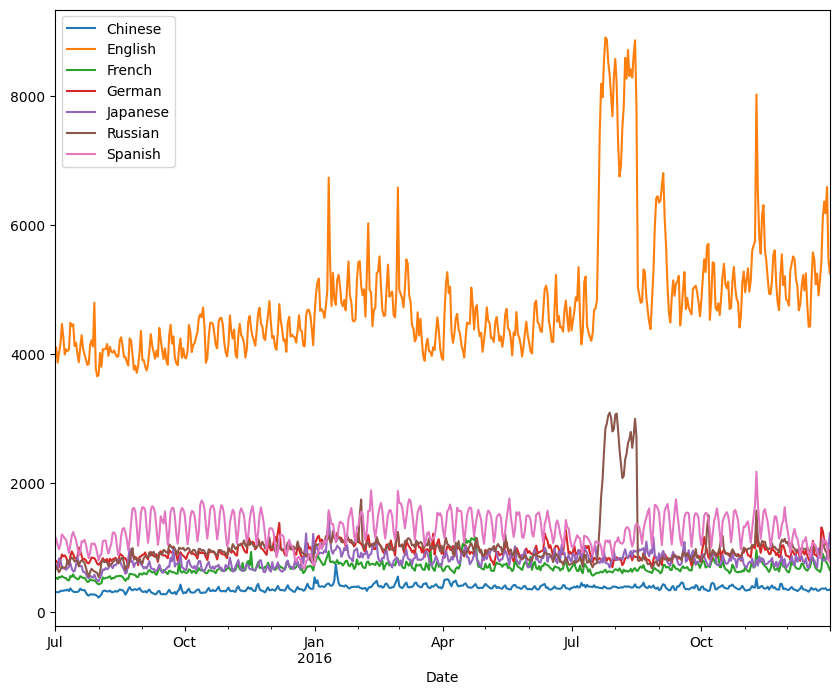

In [ ]:
for cols in list(agg_df.columns):
    agg_df[cols].plot(label=cols)
plt.legend()
plt.show()

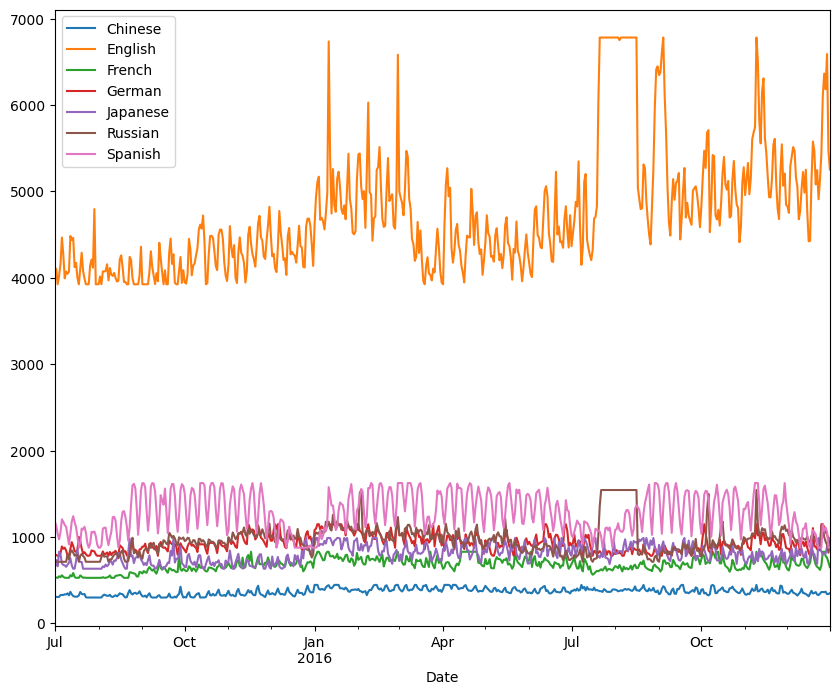

In [ ]:
for cols in agg_df.columns:
    agg_df[cols]=agg_df[cols].clip(lower=agg_df[cols].quantile(0.05),upper=agg_df[cols].quantile(0.95))
for cols in agg_df.columns:
    agg_df[cols].plot(label=cols)
plt.legend()
plt.show()

## Creating Functions

### Decomposition

In [ ]:
def decompose(dataset,language,model): #takes in (datastet=trian_data or train_data,language=English,model=Additive or Multiplicative)
  decompose_model=sma.tsa.seasonal_decompose(dataset[language],model=model)
  decompose_model.plot();

### Dickey Fuller Test

**Without Seasonality**

In [ ]:
def ad_fuller_test(dataset,language): #(dataset=agg_data or train_data,language=English)
    alpha=0.05
    p_value=sma.tsa.stattools.adfuller(dataset[language])[1]
    if p_value>alpha:
        return 1 #Non-stationary
    else:
        return 0 # Stationary

In [ ]:
#function to decide whether to differentiate or not
def decide_d(dataset,language): #(dataset=agg_data or train_data,language=English)
    if ad_fuller_test(dataset,language)==1:
        return 1
    else:
        return 0

**With Seasonality**

In [ ]:
def ad_fuller_test_seasonal(dataset,language,S): #(dataset=agg_data or train_data,language=English, S=7 )
    alpha=0.05
    p_value=sma.tsa.stattools.adfuller(dataset[language].diff(S).dropna())[1]
    if p_value>alpha:
        return 1
    else:
        return 0


In [ ]:
def decide_D(dataset,language,S): #(dataset=agg_data or train_data,language=English, S=7 )
    if ad_fuller_test_seasonal(dataset,language,S)==1:
        return 1
    else:
        return 0

### ACF and PACF

**Auto correlation**

In [ ]:
def acf(dataset,language): #(dataset=agg_data or train_data,language=English)
    d=decide_d(dataset,language)
    if d==1:
        plot_acf(dataset[language].diff(1).dropna());
    else:
        plot_acf(dataset[language]);

**Partial Auto correlation**

In [ ]:
def pacf(dataset,language): #(dataset=agg_data or train_data,language=English)
    d=decide_d(dataset,language)
    if d==1:
        plot_pacf(dataset[language].diff(1).dropna());
    else:
        plot_pacf(dataset[language]);

**Evaluation Metrics**

In [ ]:
def performance(actual,predicted):
    print('Mean Absolute Error:',round(mae(actual,predicted),3))
    print('Root Mean Squared Error:',round(mse(actual,predicted)**0.5,3))
    print('Mean Absolute Percentage Error:',round(mape(actual,predicted)*100,3))

### **ARIMA**

In [ ]:
def arima(dataset,language): #(dataset=agg_data or train_data,language=English)

    #deciding the value of d
    d=decide_d(dataset,language)
    best_mape=100
    best_p=0
    best_q=0

    #loop to find the best p and q values
    for p in range(1,7):
        for q in range(1,7):
            arima_model=SARIMAX(dataset[language],order=(p,d,q))
            arima_model=arima_model.fit(disp=False)
            prediction=arima_model.forecast(steps=len(test_data))

            mape_score=round(mape(test_data[language],prediction)*100,3)
            if mape_score<best_mape:
                best_mape=mape_score
                best_p=p
                best_q=q

    #prediction using the best parameters
    arima_model=SARIMAX(dataset[language],order=(best_p,d,best_q))
    arima_model=arima_model.fit(disp=False)
    prediction=arima_model.forecast(steps=len(test_data))



    print(language,':')
    print('Past values:',best_p)
    print('Past error:',best_q)
    performance(test_data[language],prediction)

    dataset[language].plot(label='Training')
    test_data[language].plot(label='Actual')
    prediction.plot(label='Predicted')
    plt.legend()
    plt.show()

    return [language,best_p,d,best_q,best_mape]



In [ ]:
def arima_analyse(dataset): #just input the dataset
    scores_list=[]

    #iteration for all languages
    for cols in agg_df.columns:
        scores_list.append(arima(dataset,cols))
    arima_params_data=pd.DataFrame(scores_list,columns=['Language','p','d','q','mape'])
    return arima_params_data

### **SARIMA**

In [ ]:
def sarima(dataset,language,S):

    #deciding the value of d
    d=decide_d(dataset,language)
    D=decide_D(dataset,language,S)

    best_mape=100
    best_p=0
    best_q=0
    best_P=0
    best_Q=0

    #loop to find the best p,q,P,Q values
    for p in range(1,2):
        for q in range(1,2):
            for P in range(0,2):
                for Q in range(0,2):
                    sarima_model=SARIMAX(dataset[language],order=(p,d,q),seasonal_order=(P,D,Q,S))
                    sarima_model=sarima_model.fit(disp=False)
                    prediction=sarima_model.forecast(steps=len(test_data))

                    mape_score=round(mape(test_data[language],prediction)*100,3)
                    if mape_score<best_mape:
                        best_mape=mape_score
                        best_p=p
                        best_q=q
                        best_P=P
                        best_Q=Q

    #predictions with best parameter
    sarima_model=SARIMAX(dataset[language],order=(best_p,d,best_q),seasonal_order=(best_P,D,best_Q,S))
    sarima_model=sarima_model.fit(disp=False)
    prediction=sarima_model.forecast(steps=len(test_data))

    print(language,':')
    print('Past values:',best_p)
    print('Past errors:',best_q)
    print('Past seasonal values:',best_P)
    print('Past seasonal errors:',best_Q)
    performance(test_data[language],prediction)

    #plotting
    dataset[language].plot(label='Training')
    test_data[language].plot(label='Actual')
    prediction.plot(label='Predicted')
    plt.legend()
    plt.show()

    return [language,best_p,d,best_q,best_P,D,best_Q,S,best_mape]

In [ ]:
def sarima_analyse(dataset,S): #(dataset=train_data,S=7)
    scores_list=[]
    for cols in agg_df.columns:
        scores_list.append(sarima(dataset,cols,S))
    sarima_params_data=pd.DataFrame(scores_list,columns=['language','p','d','q','P','D','Q','S','mape'])
    return sarima_params_data

### **SARIMAX**

In [ ]:
def sarimax(dataset,language,S,exog):

    #deciding the value of d
    d=decide_d(dataset,language)
    D=decide_D(dataset,language,S)

    best_mape=100
    best_p=0
    best_q=0
    best_P=0
    best_Q=0

    #hyperparameter tuning
    for p in range(1,2):
        for q in range(1,2):
            for P in range(0,2):
                for Q in range(0,2):
                    sarimax_model=SARIMAX(dataset[language],order=(p,d,q),seasonal_order=(P,D,Q,S),exog=dataset[exog])
                    sarimax_model=sarimax_model.fit(disp=False)
                    predicted=sarimax_model.forecast(steps=len(test_data),exog=test_data[exog])

                    mape_score=round(mape(test_data[language],predicted)*100,3)

                    if mape_score<best_mape:
                        best_mape=mape_score
                        best_p=p
                        best_q=q
                        best_P=P
                        best_Q=Q

    #prediction with best hyperparameter
    sarimax_model=SARIMAX(dataset[language],order=(best_p,d,best_q),seasonal_order=(best_P,D,best_Q,S),exog=dataset[exog])
    sarimax_model=sarimax_model.fit(disp=False)
    predicted=sarimax_model.forecast(steps=len(test_data),exog=test_data[exog])

    print(language,':')
    print('Past values:',best_p)
    print('Past errors:',best_q)
    print('Past seasonal values:',best_P)
    print('Past seasonal errors:',best_Q)

    #visualisation
    performance(test_data[language],predicted)
    dataset[language].plot(label='Training')
    test_data[language].plot(label='Actual')
    predicted.plot(label='Predicted')
    plt.legend()
    plt.show()

### FB Prophet

In [ ]:
def fb_prophet(dataset):

  pro_model=Prophet(interval_width=0.9,weekly_seasonality=True,changepoint_prior_scale=1)
  pro_model.add_regressor('exog')
  pro_model.fit(dataset[:500])
  forecast=pro_model.predict(dataset)
  fig=pro_model.plot(forecast)

  #Visualization
  plt.plot(dataset['ds'],dataset['y'],label='Actual')
  plt.plot(dataset['ds'],forecast['yhat'],label='Predicted')
  plt.legend()
  plt.show()

  performance(dataset['y'][:500],forecast['yhat'][:500])

## Train-test split

In [ ]:
train_data=agg_df[:500] #first 500 values for training
test_data=agg_df[500:] #last 50 values for testing

### Understanding exogenous variable

In [ ]:
exog=pd.read_csv('Exog_Campaign_eng')
exog.index=pd.date_range(start=agg_df.index[0],periods=550,freq='D')
exog.head()

Exog
2015-07-01     0
2015-07-02     0
2015-07-03     0
2015-07-04     0
2015-07-05     0

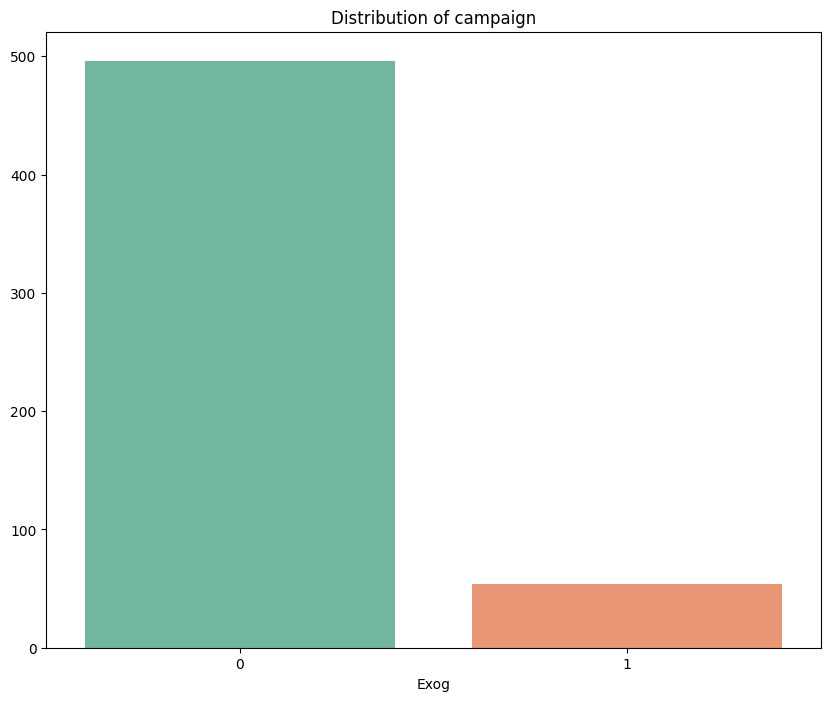

In [ ]:
x=exog.groupby('Exog')['Exog'].count().index
y=exog.groupby('Exog')['Exog'].count().values
sns.barplot(x=x,y=y,palette='Set2')
plt.title('Distribution of campaign')
plt.show()

**Observation:**

Out of 550 days, campaigns have been conducted for very few days i.e around 50 days.

In [ ]:
#adding exogenous to the training and testing dataset
train_data.loc[:,'exog']=exog['Exog'][:500]
test_data.loc[:,'exog']=exog['Exog'][500:]

In [ ]:
print('Dimension of training data:',train_data.shape)
print('Dimenssion of test data:',test_data.shape)

Dimension of training data: (500, 8)
Dimenssion of test data: (50, 8)


## Dataset preparation for Prophet

In [ ]:
prophet_data=agg_df[['English']]

In [ ]:
prophet_data['exog']=exog['Exog']

In [ ]:
prophet_data.reset_index(inplace=True)

In [ ]:
prophet_data.columns=['ds','y','exog']

In [ ]:
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      550 non-null    datetime64[ns]
 1   y       550 non-null    float64       
 2   exog    550 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.0 KB


In [ ]:
prophet_data.head()

ds            y  exog
0 2015-07-01  4121.645453     0
1 2015-07-02  4099.554595     0
2 2015-07-03  3925.366964     0
3 2015-07-04  4022.904083     0
4 2015-07-05  4159.763729     0

## Statsmodel Decomposition

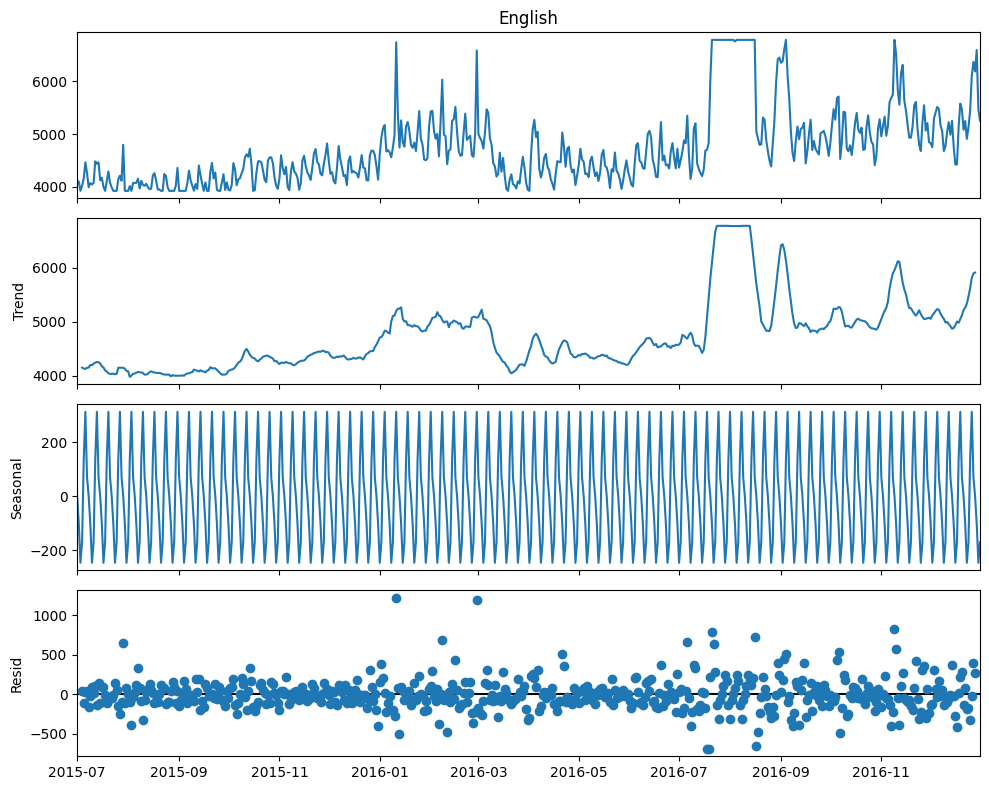

In [ ]:
decompose(agg_df,'English','additive')

## ACF and PACF visualisation

### ACF

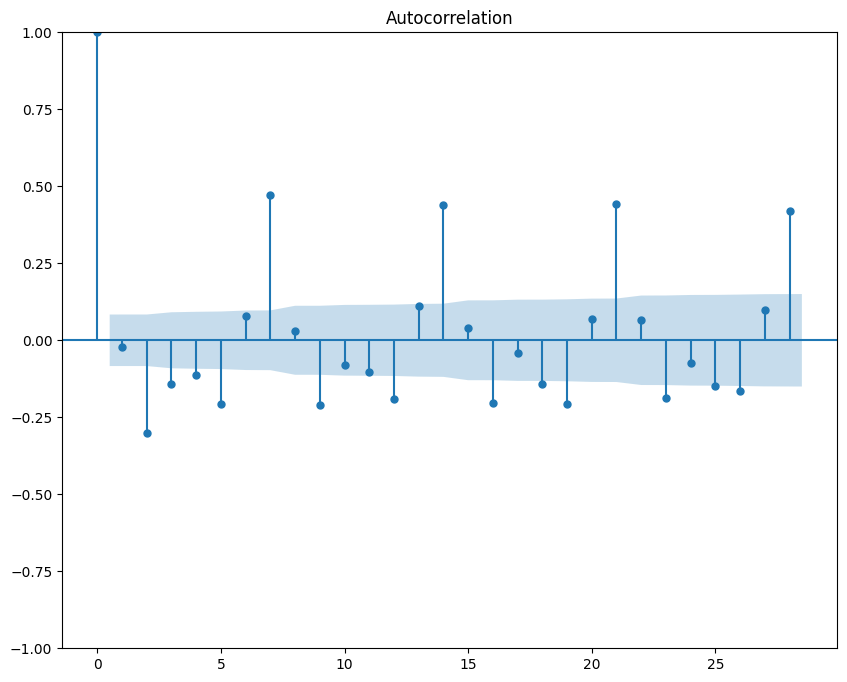

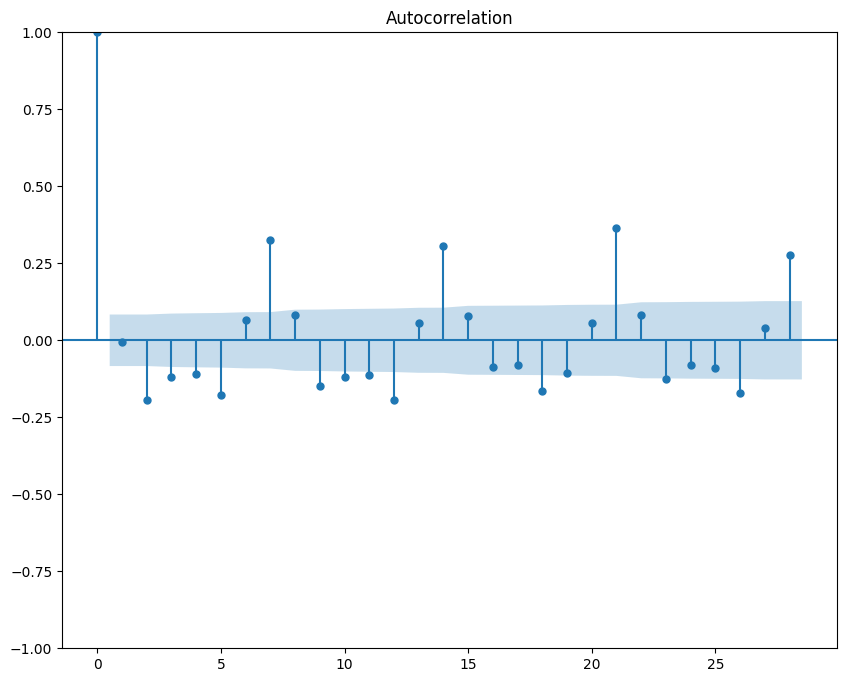

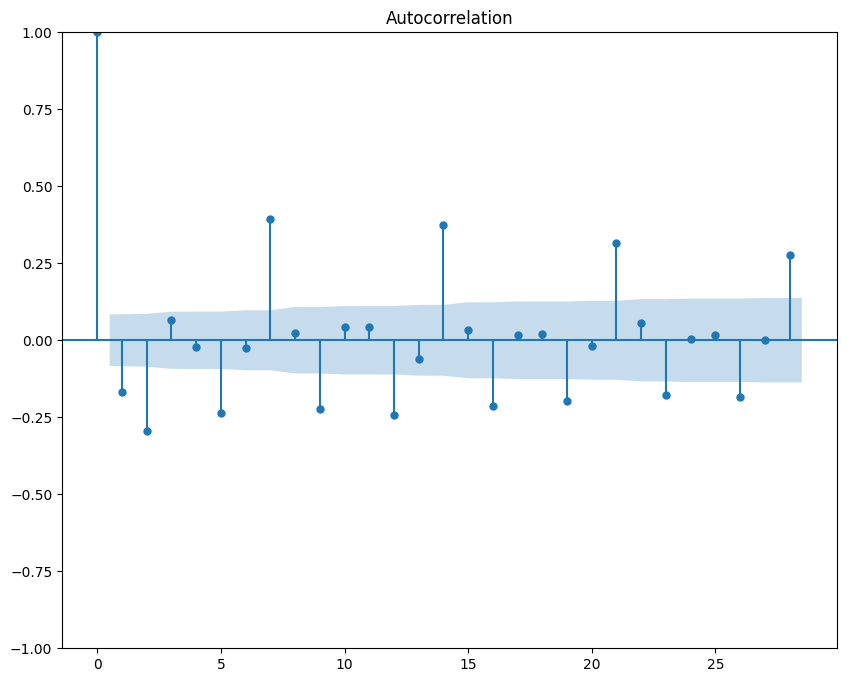

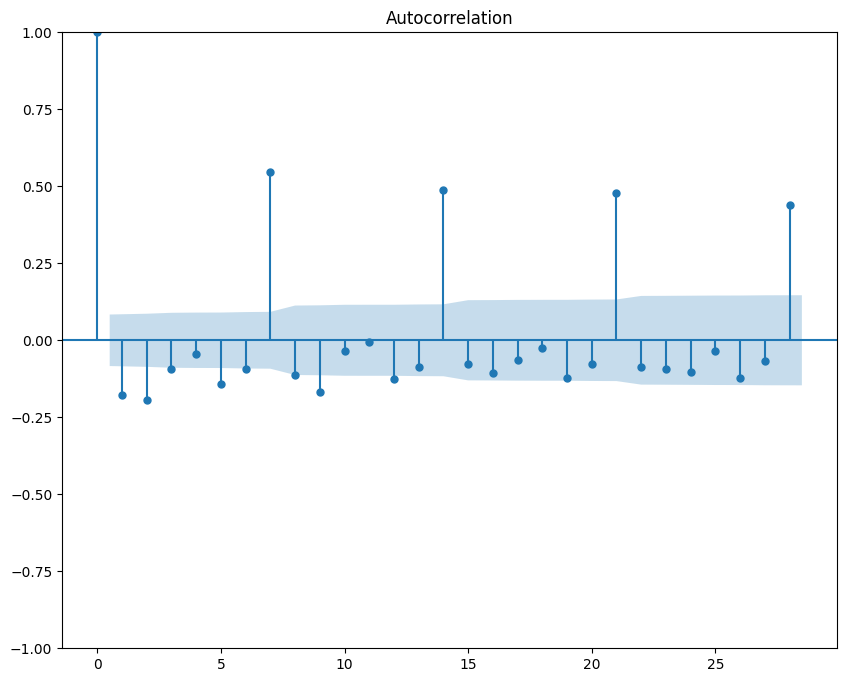

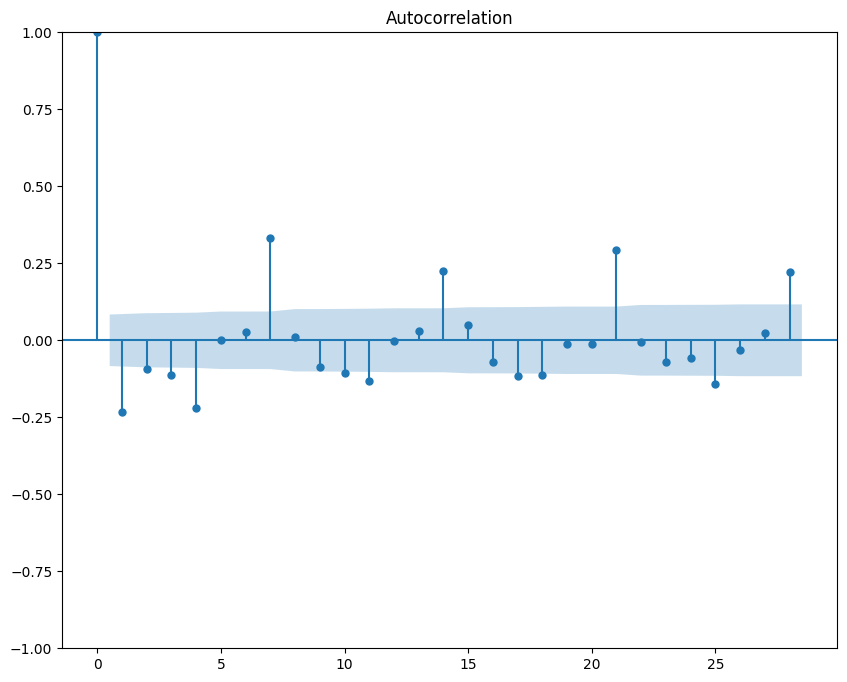

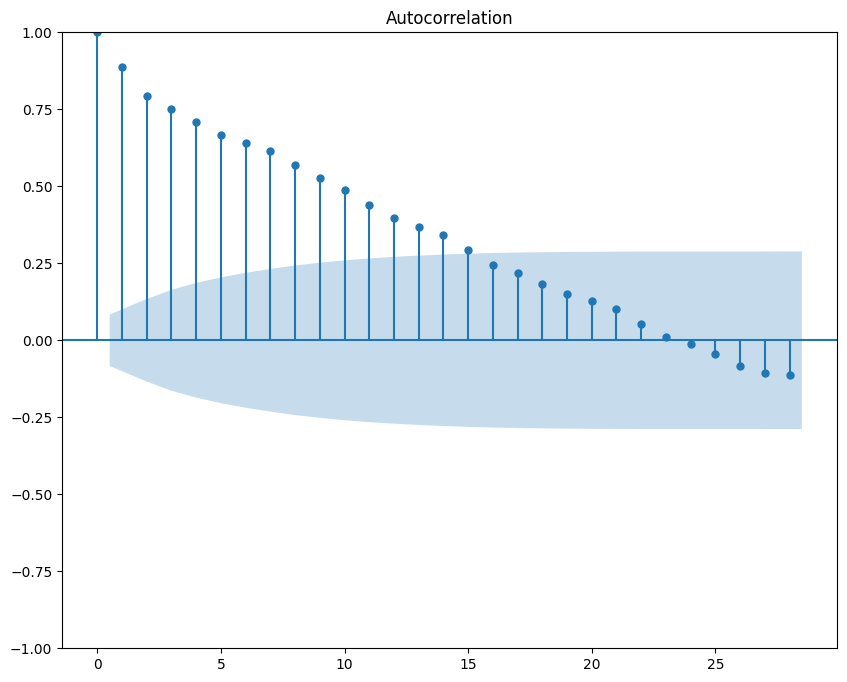

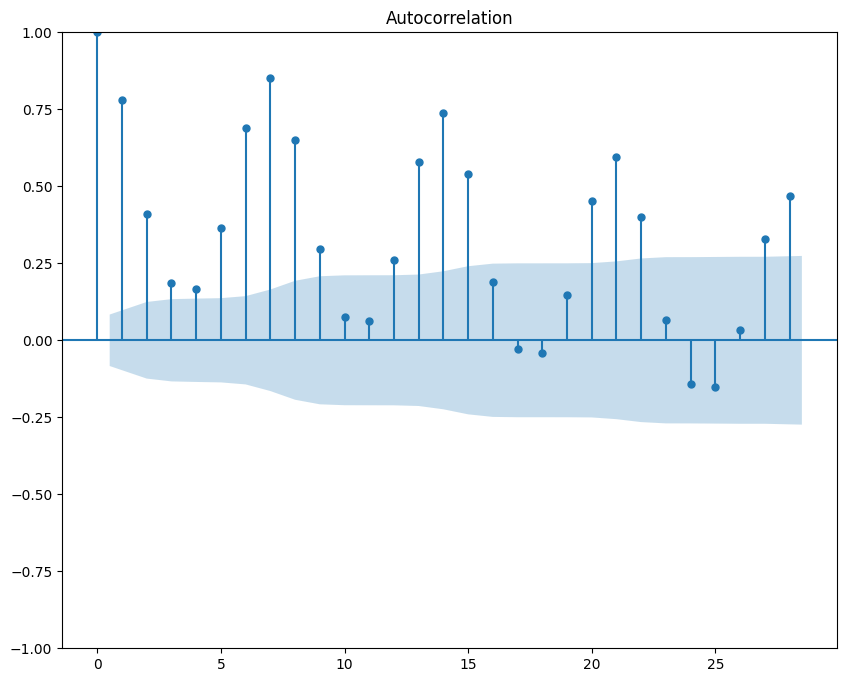

In [ ]:
for cols in agg_df.columns:
  acf(agg_df,cols)

### PACF

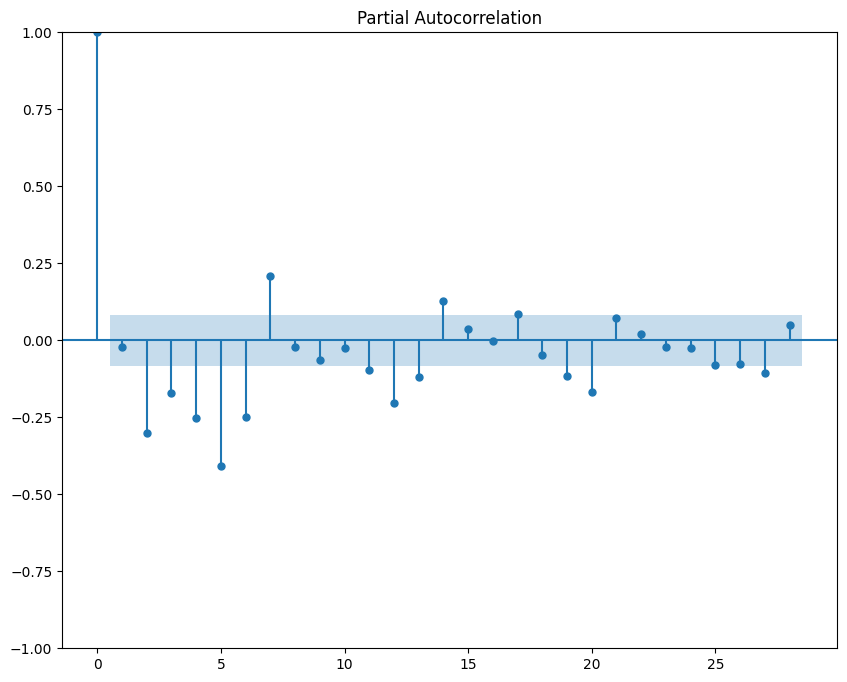

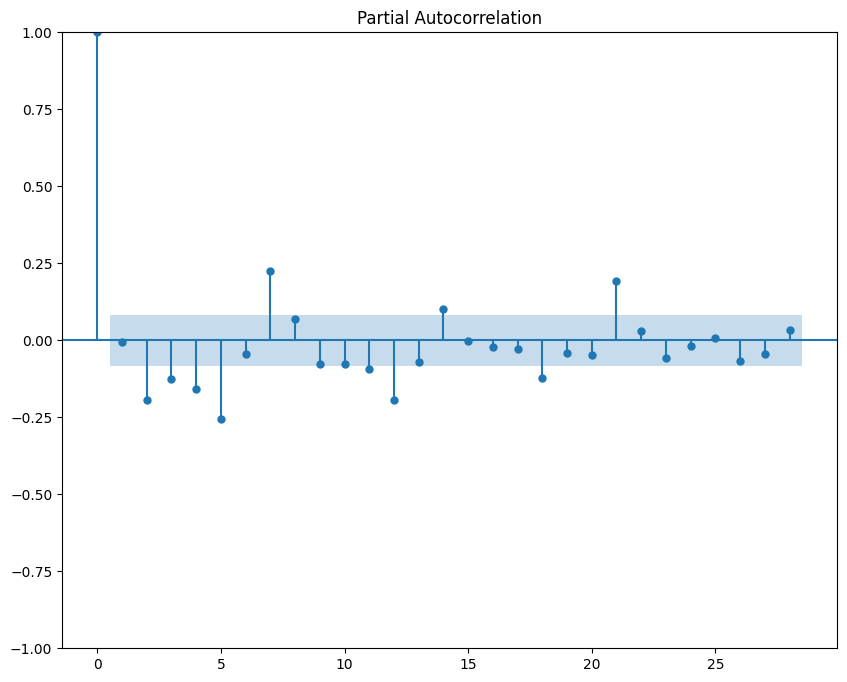

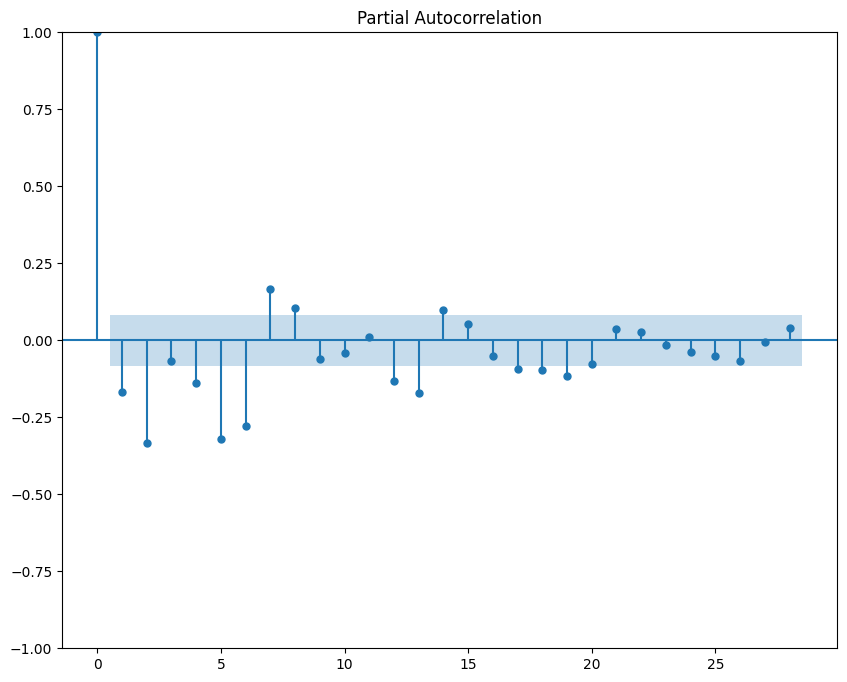

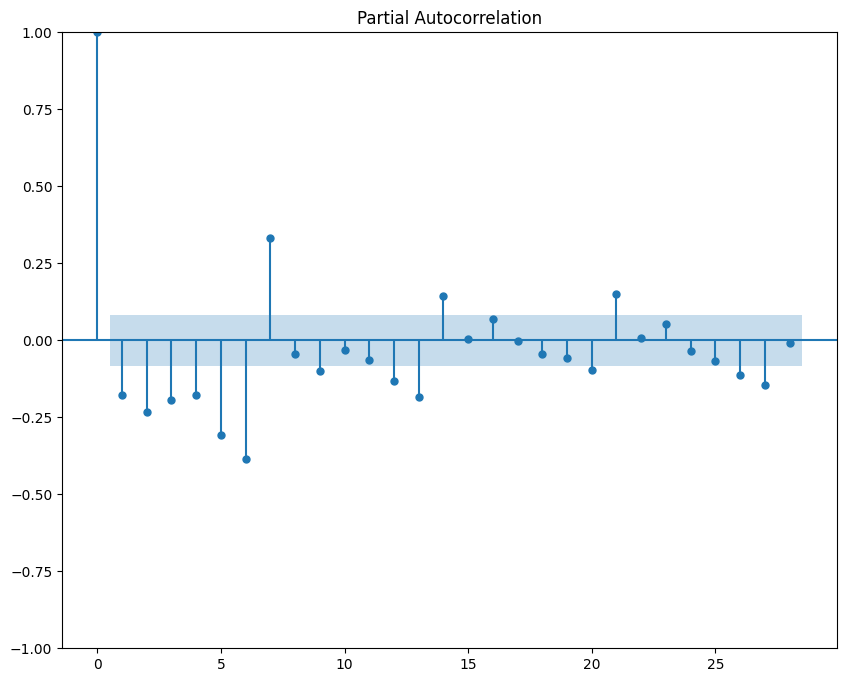

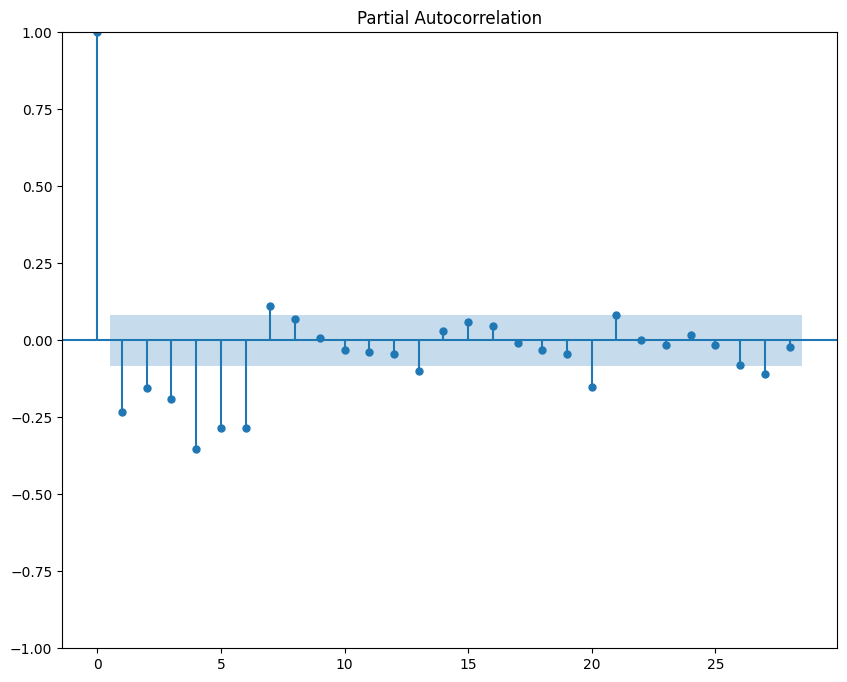

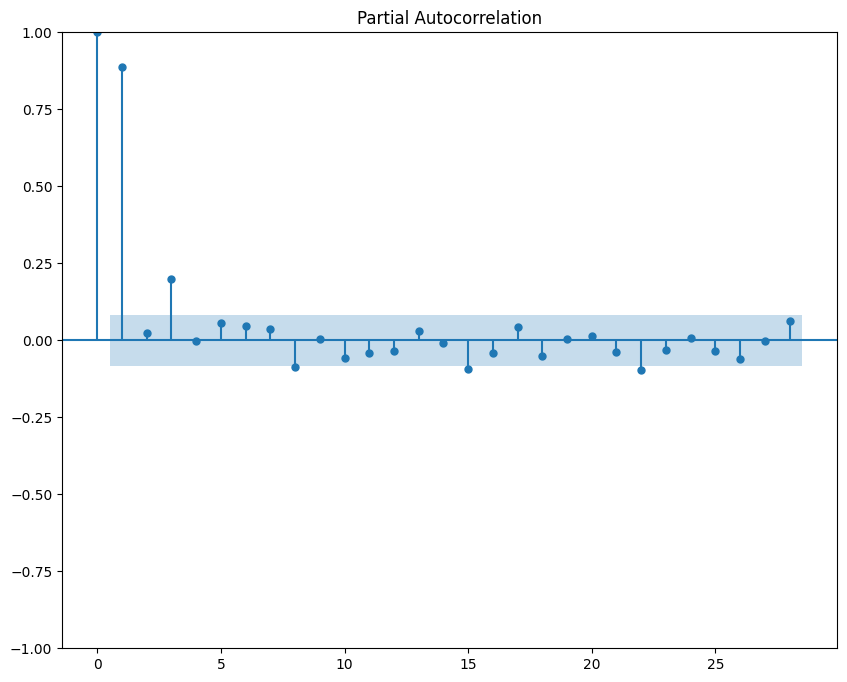

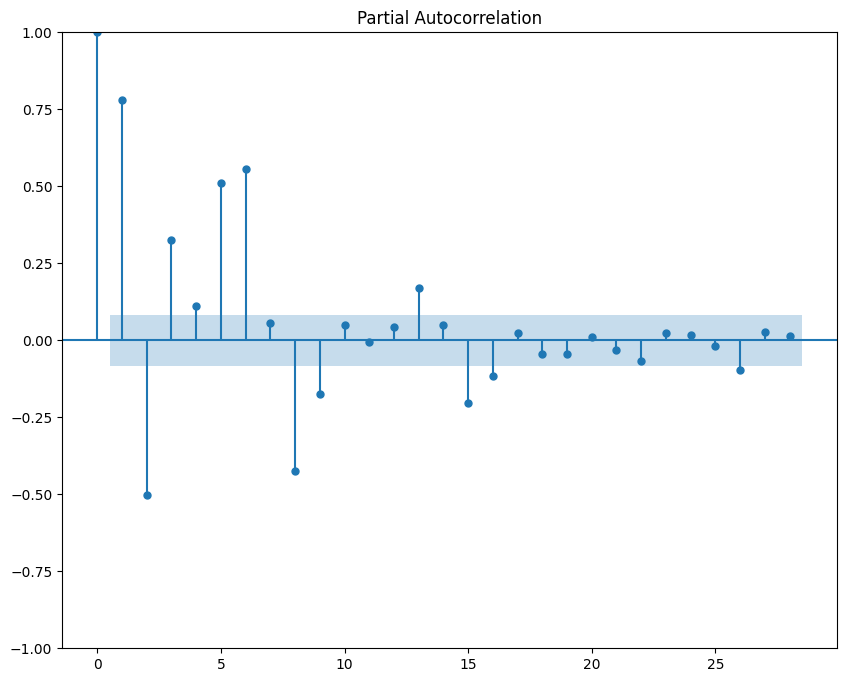

In [ ]:
for cols in agg_df.columns:
  pacf(agg_df,cols)

## Training and Testing using all models

### ARIMA

Chinese :
Past values: 2
Past error: 2
Mean Absolute Error: 21.958
Root Mean Squared Error: 26.736
Mean Absolute Percentage Error: 6.123


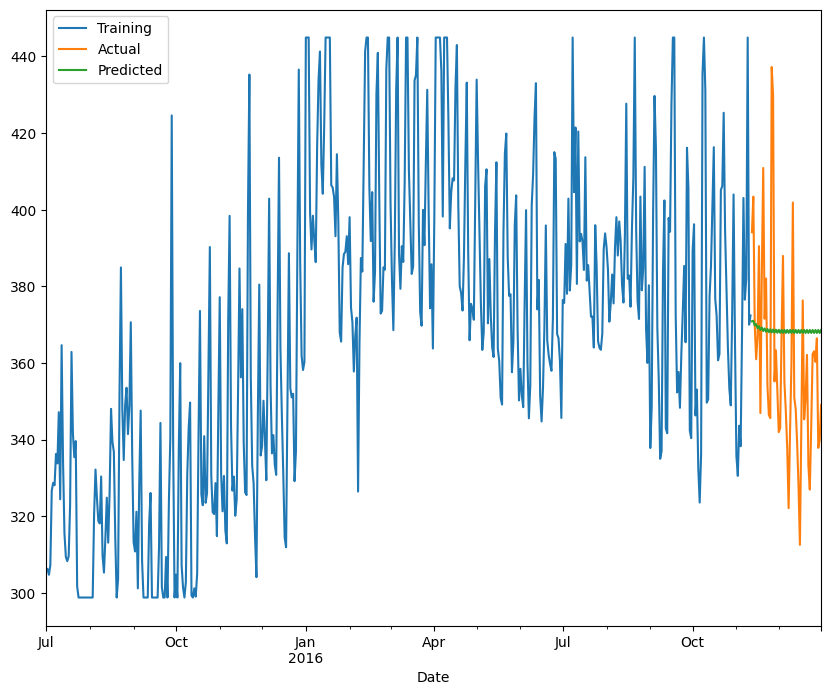

English :
Past values: 6
Past error: 6
Mean Absolute Error: 371.229
Root Mean Squared Error: 521.668
Mean Absolute Percentage Error: 6.781


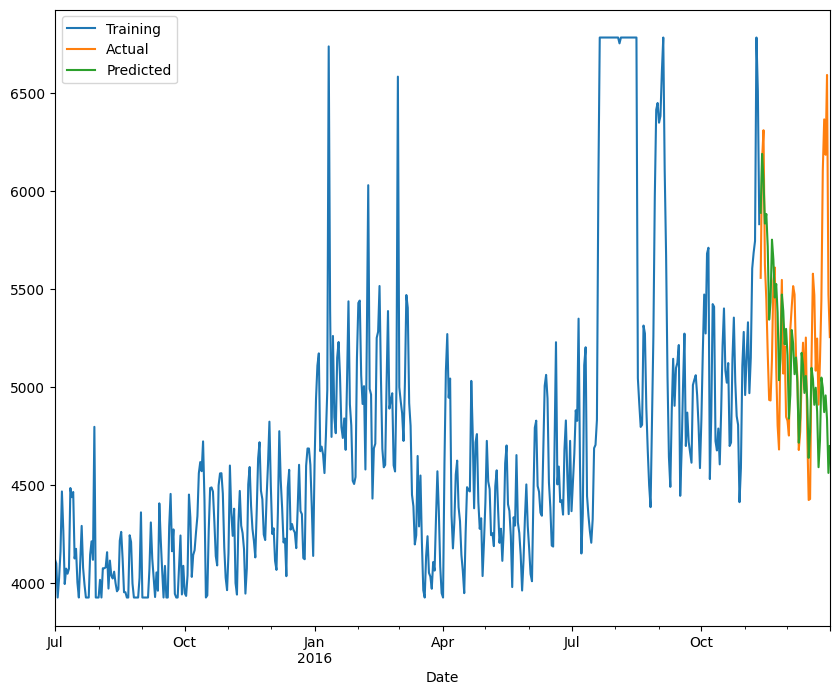

French :
Past values: 3
Past error: 3
Mean Absolute Error: 50.825
Root Mean Squared Error: 60.613
Mean Absolute Percentage Error: 7.318


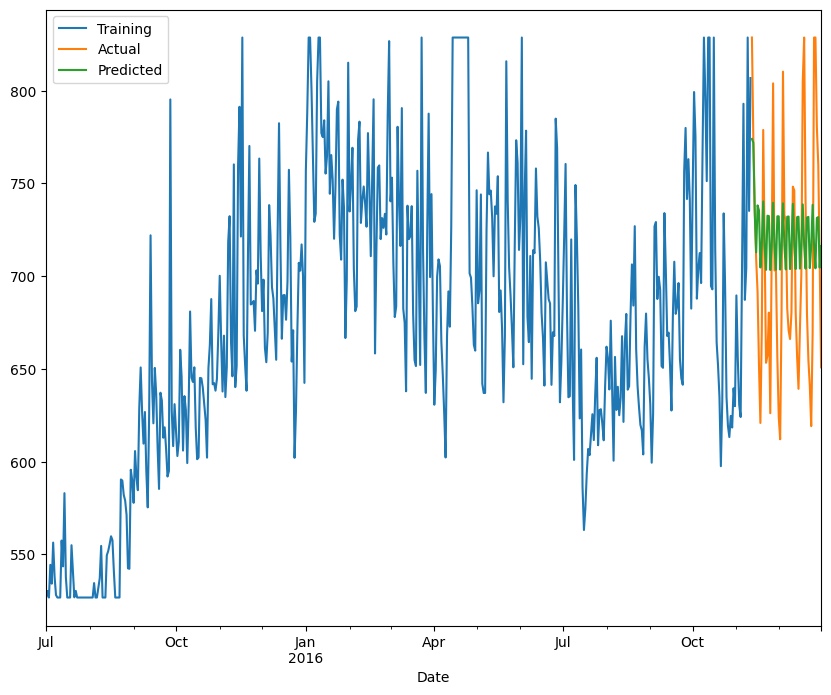

German :
Past values: 3
Past error: 5
Mean Absolute Error: 68.833
Root Mean Squared Error: 86.168
Mean Absolute Percentage Error: 7.414


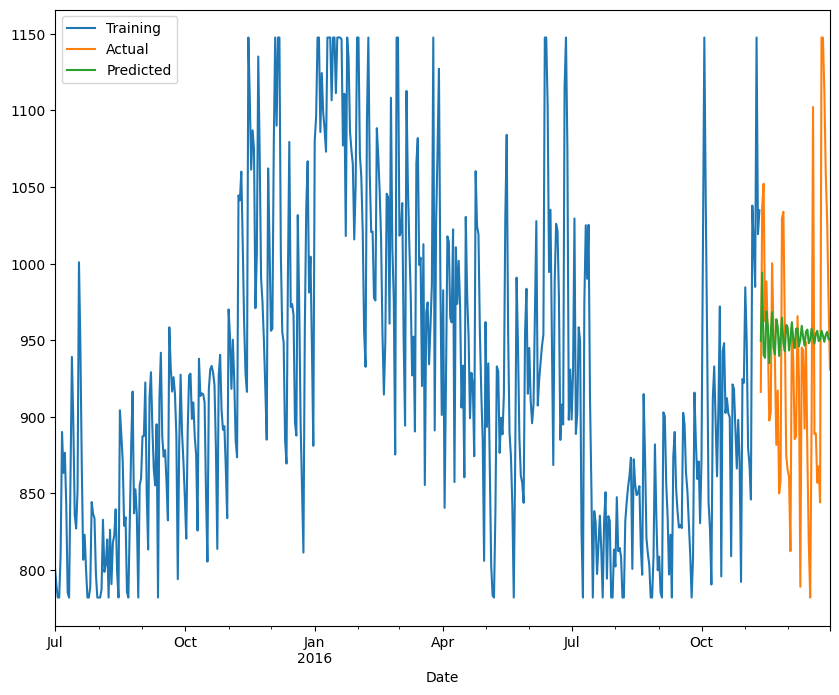

Japanese :
Past values: 4
Past error: 6
Mean Absolute Error: 51.533
Root Mean Squared Error: 69.345
Mean Absolute Percentage Error: 6.297


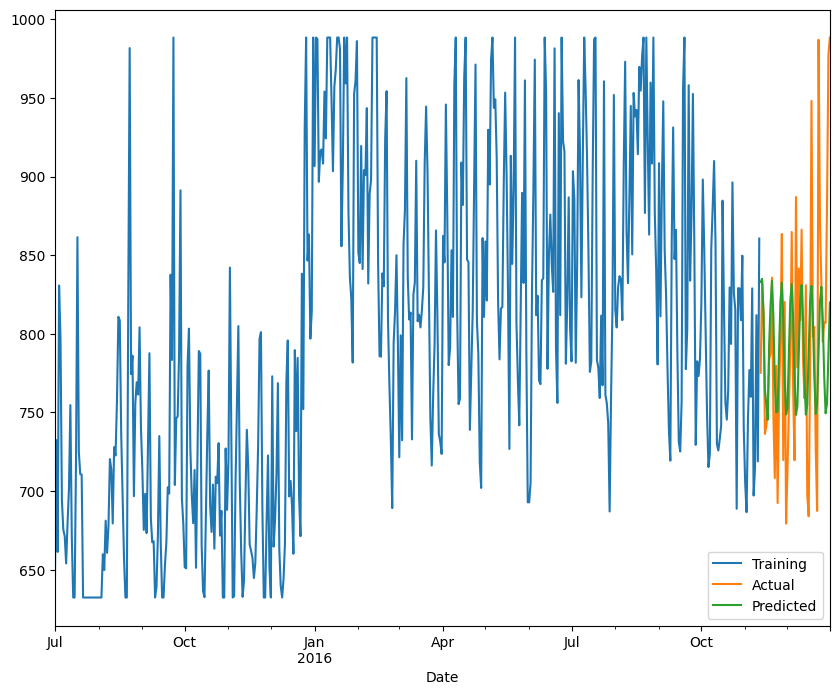

Russian :
Past values: 1
Past error: 1
Mean Absolute Error: 49.249
Root Mean Squared Error: 65.229
Mean Absolute Percentage Error: 4.806


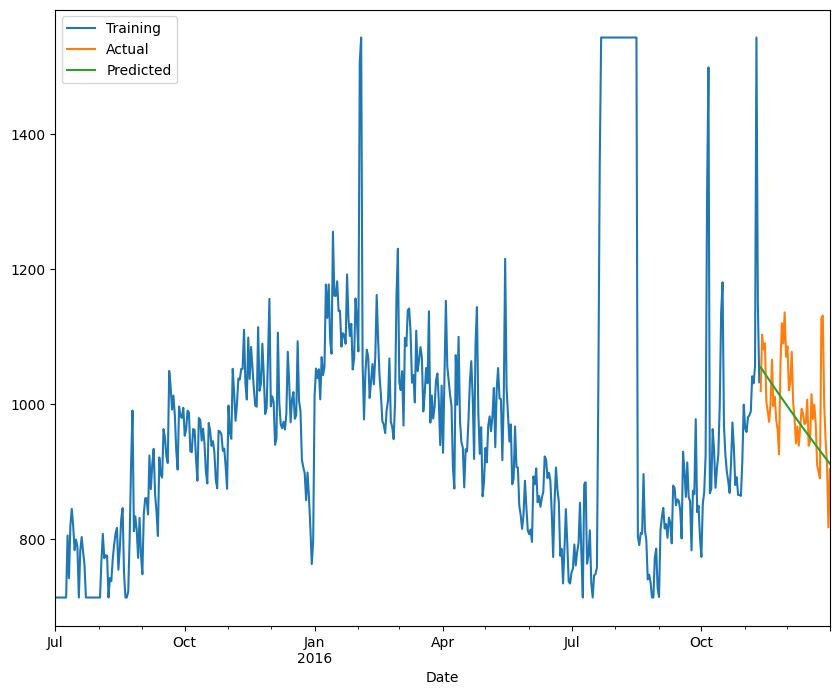

Spanish :
Past values: 4
Past error: 1
Mean Absolute Error: 148.089
Root Mean Squared Error: 177.09
Mean Absolute Percentage Error: 14.028


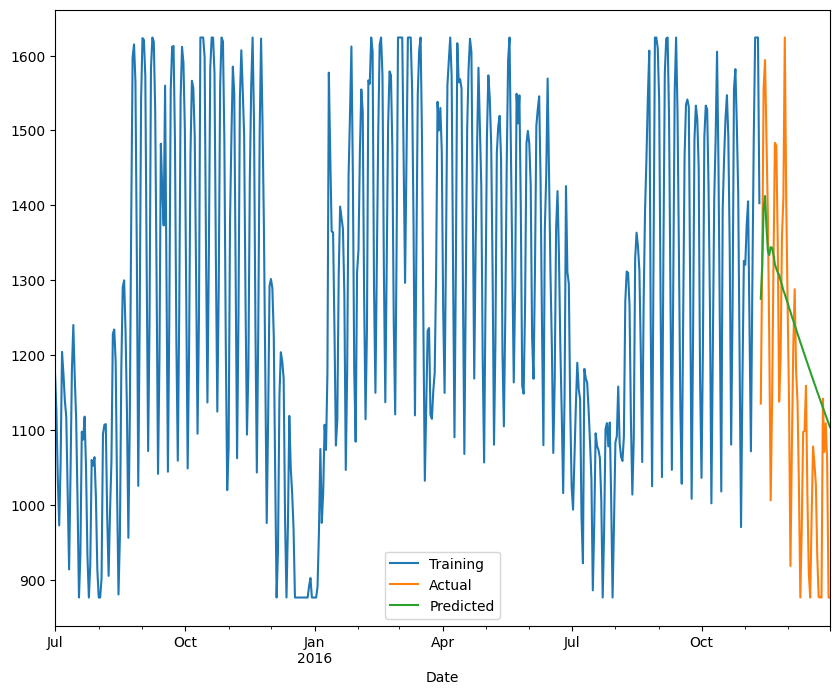

In [ ]:
arima_scores=arima_analyse(train_data)

### SARIMA

Chinese :
Past values: 1
Past errors: 1
Past seasonal values: 1
Past seasonal errors: 1
Mean Absolute Error: 21.543
Root Mean Squared Error: 25.026
Mean Absolute Percentage Error: 6.113


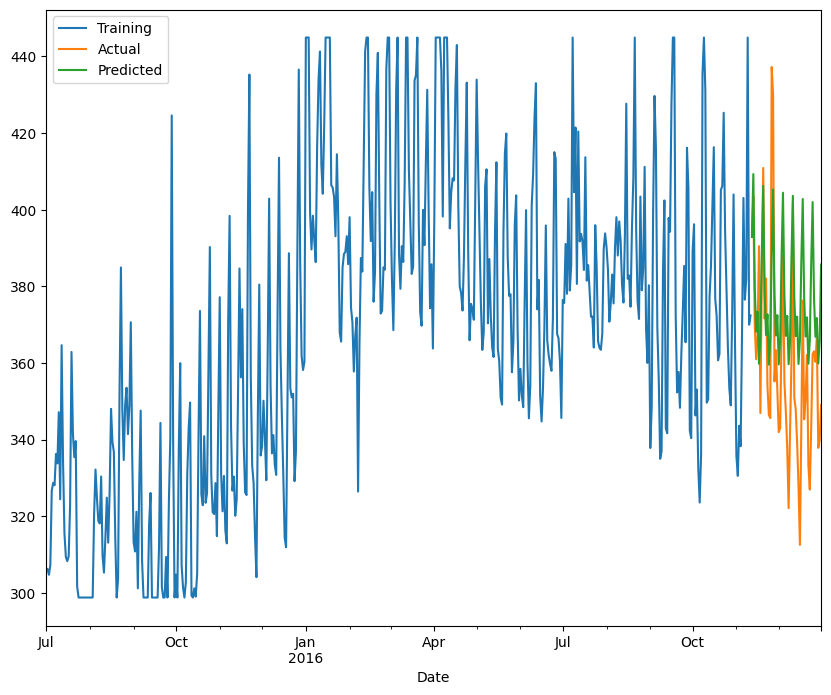

English :
Past values: 1
Past errors: 1
Past seasonal values: 1
Past seasonal errors: 1
Mean Absolute Error: 338.145
Root Mean Squared Error: 437.714
Mean Absolute Percentage Error: 6.436


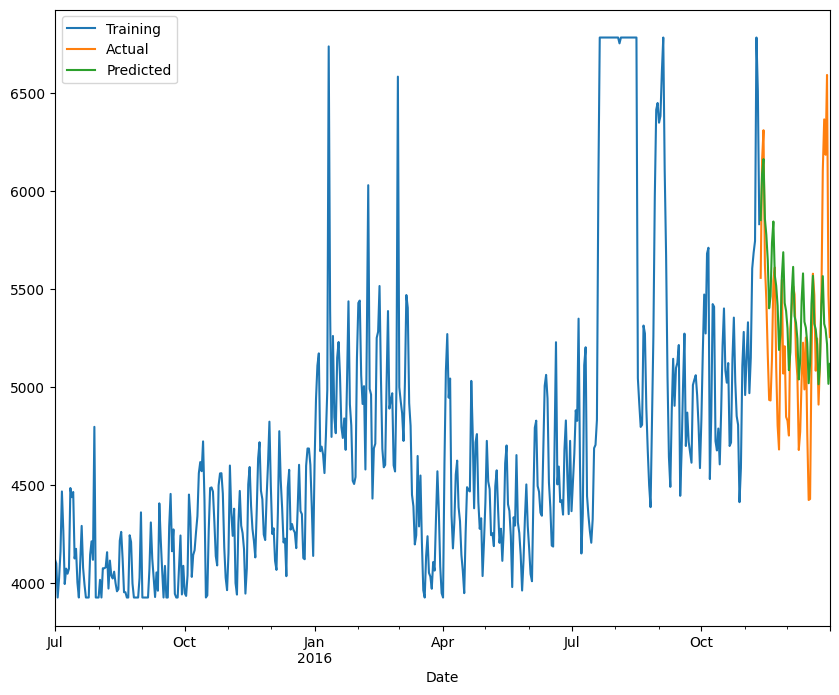

French :
Past values: 1
Past errors: 1
Past seasonal values: 0
Past seasonal errors: 0
Mean Absolute Error: 55.338
Root Mean Squared Error: 63.43
Mean Absolute Percentage Error: 7.974


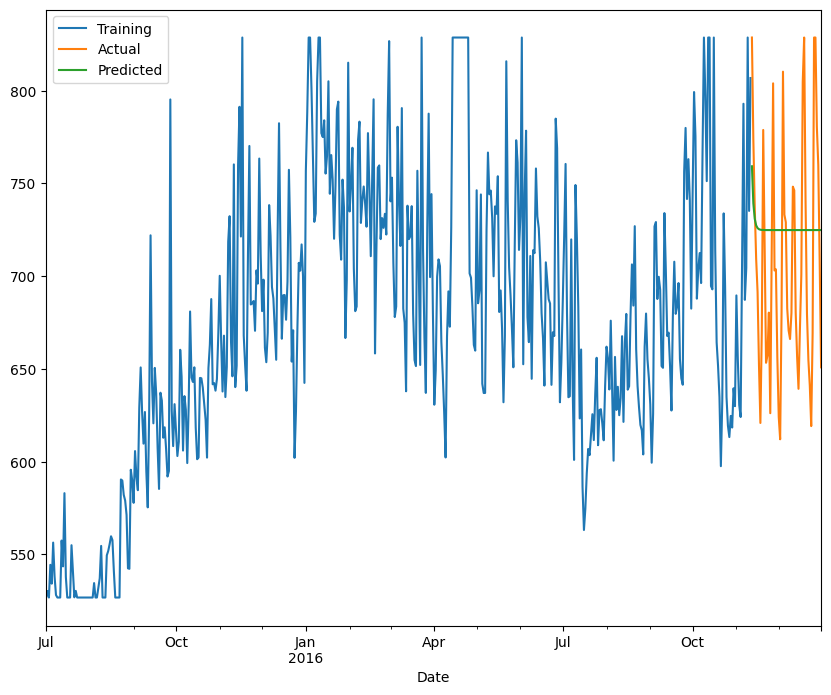

German :
Past values: 1
Past errors: 1
Past seasonal values: 0
Past seasonal errors: 1
Mean Absolute Error: 75.335
Root Mean Squared Error: 90.801
Mean Absolute Percentage Error: 8.211


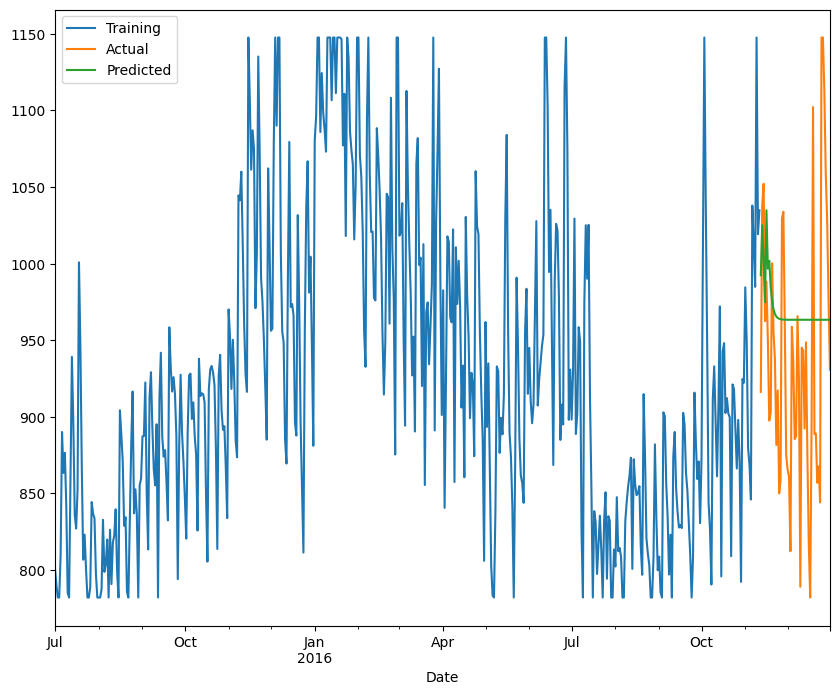

Japanese :
Past values: 1
Past errors: 1
Past seasonal values: 1
Past seasonal errors: 1
Mean Absolute Error: 49.862
Root Mean Squared Error: 72.642
Mean Absolute Percentage Error: 6.006


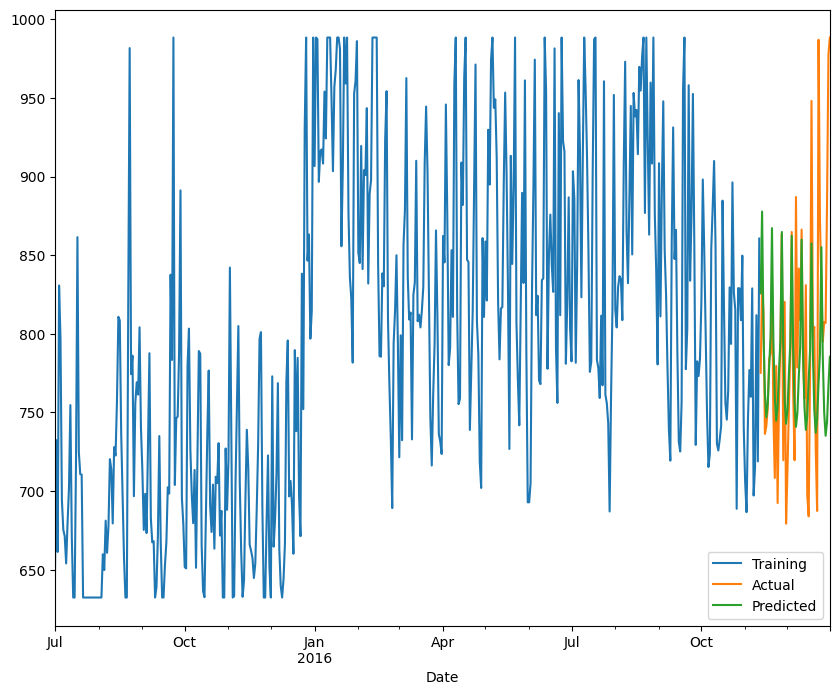

Russian :
Past values: 1
Past errors: 1
Past seasonal values: 1
Past seasonal errors: 1
Mean Absolute Error: 39.902
Root Mean Squared Error: 55.067
Mean Absolute Percentage Error: 3.905


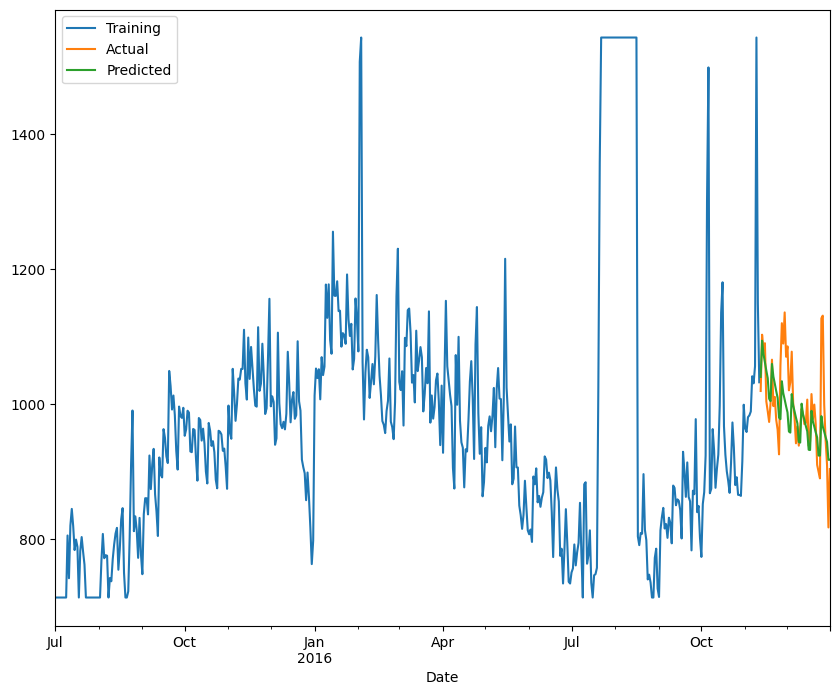

Spanish :
Past values: 1
Past errors: 1
Past seasonal values: 1
Past seasonal errors: 0
Mean Absolute Error: 205.748
Root Mean Squared Error: 228.986
Mean Absolute Percentage Error: 19.162


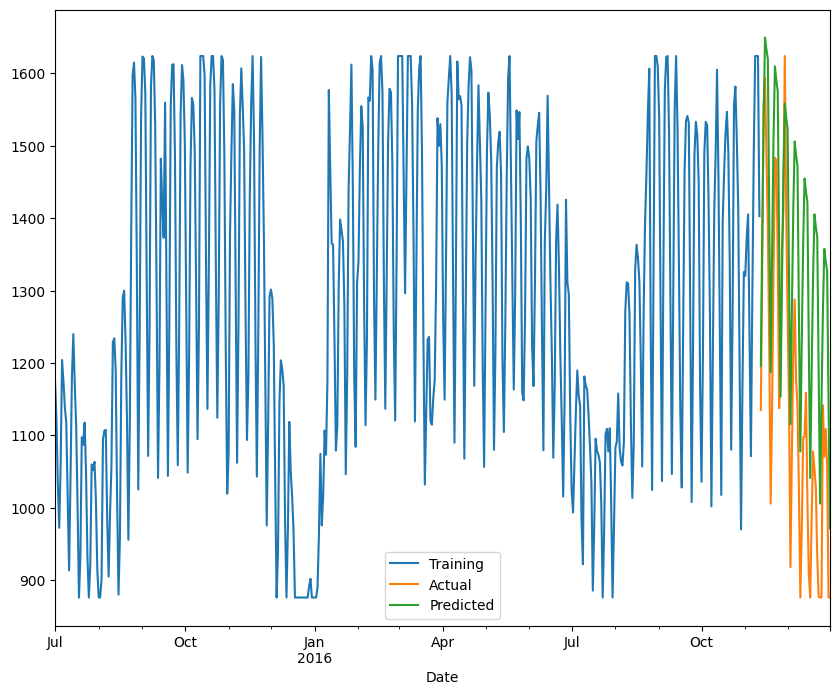

In [ ]:
sarima_scores=sarima_analyse(train_data,7)

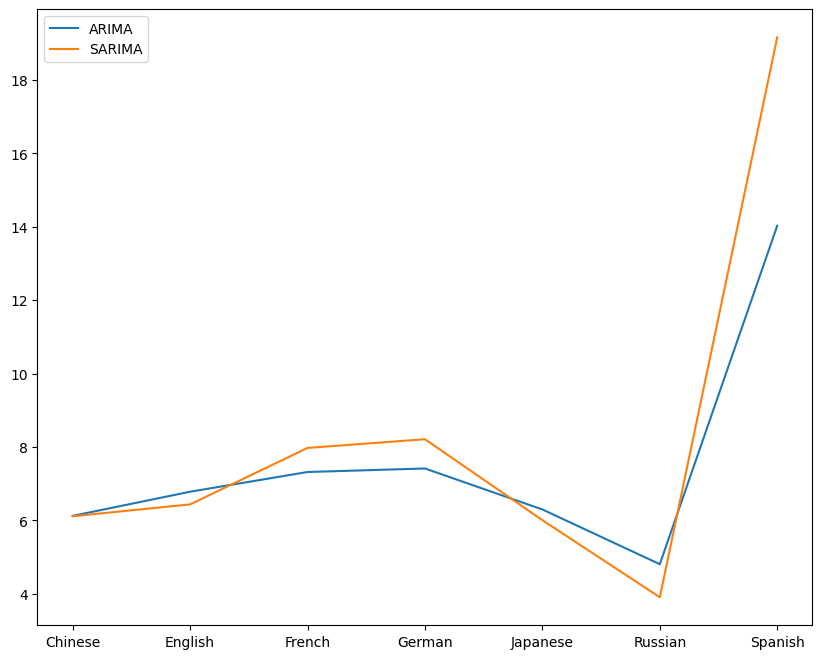

In [ ]:
plt.plot(arima_scores['Language'],arima_scores['mape'],label='ARIMA')
plt.plot(sarima_scores['language'],sarima_scores['mape'],label='SARIMA')
plt.legend()
plt.show()

**Observation:**



*   Both ARIMA and SARIMA models were able to achieve a MAPE value around 8% for all langauges except Spanish.
*   The MAPE for Spanish in ARIMA is 14.02% and SARIMA is 19.16%.





### SARIMAX

English :
Past values: 1
Past errors: 1
Past seasonal values: 0
Past seasonal errors: 1
Mean Absolute Error: 288.514
Root Mean Squared Error: 362.364
Mean Absolute Percentage Error: 5.667


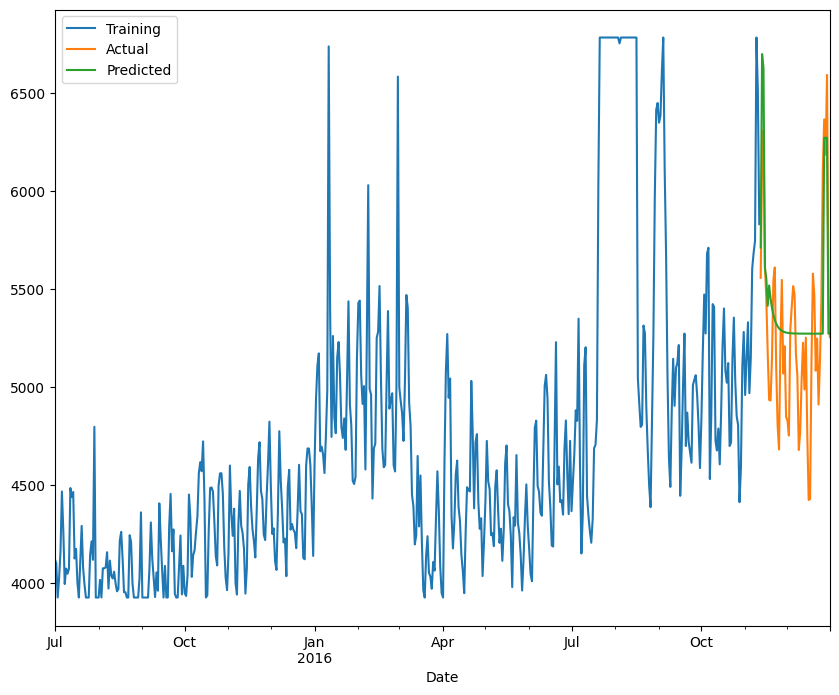

In [ ]:
sarimax(train_data,'English',7,'exog')

**Observation**

The MAPE for English using SARIMAX is almost 5.6%

### Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfd1hb01k/cqcx6yr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfd1hb01k/kpyhhvo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3092', 'data', 'file=/tmp/tmpfd1hb01k/cqcx6yr7.json', 'init=/tmp/tmpfd1hb01k/kpyhhvo0.json', 'output', 'file=/tmp/tmpfd1hb01k/prophet_model1gh3ag4b/prophet_model-20240803063229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


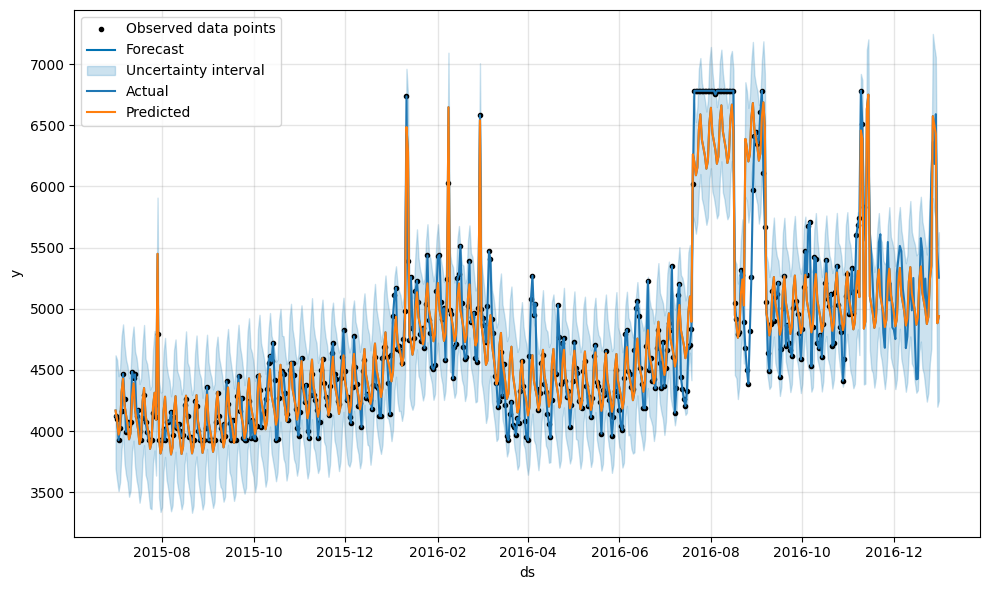

Mean Absolute Error: 186.024
Root Mean Squared Error: 288.461
Mean Absolute Percentage Error: 3.837


In [ ]:
fb_prophet(prophet_data)

**OBSERVATION:**

The best MAPE for English language is found using Prophet model with exogenous variable is 3.8%

## Rcommendations

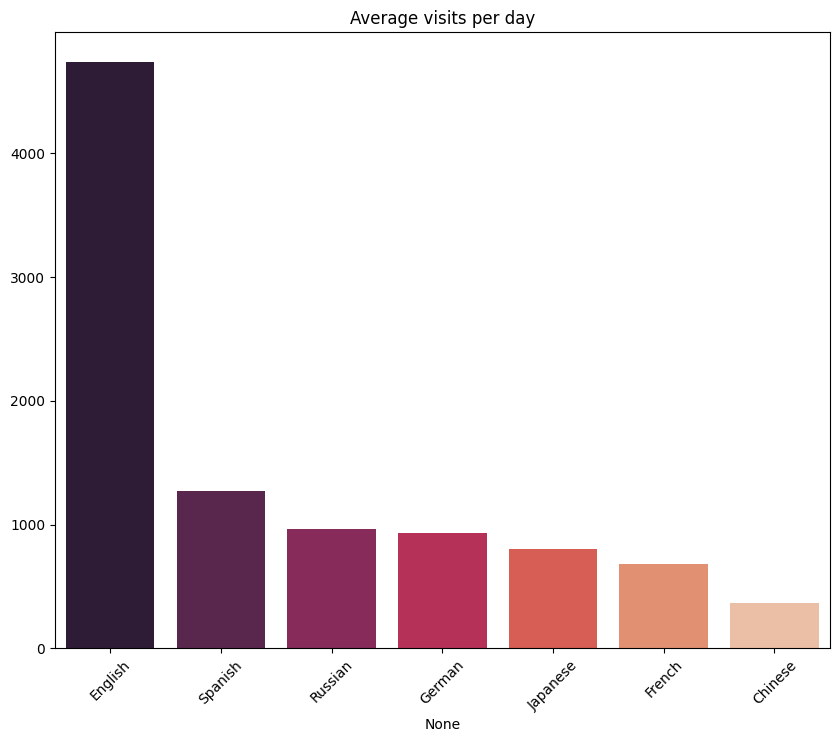

In [ ]:
sns.barplot(x=agg_df.mean().sort_values(ascending=False).index,y=agg_df.mean().sort_values(ascending=False).values,palette='rocket')
plt.title('Average visits per day')
plt.xticks(rotation=45)
plt.show()

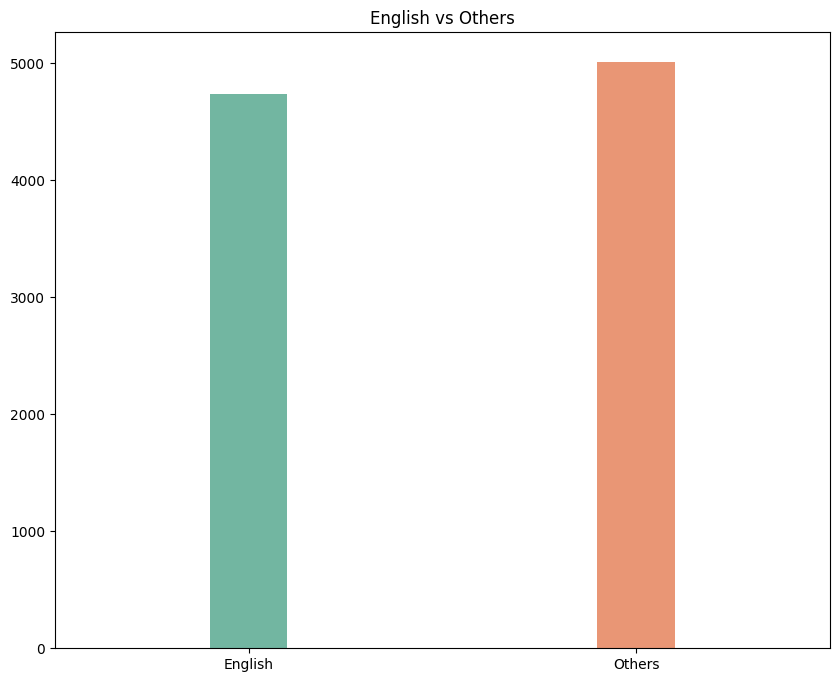

In [ ]:
English=agg_df.mean().sort_values(ascending=False)[0]
Others=sum(agg_df.mean().sort_values(ascending=False)[1:])
sns.barplot(x=['English','Others'],y=[English,Others],palette='Set2',width=0.2)
plt.title('English vs Others')
plt.show()





*   English language has the maximum average visits per day. Clients can put their ads on any English website to reach more people.
*   In the second plot it is visible that the combination of all other languages surpasses average daily visit of English.

*   If the client prefers to reach people from wider region rather than just one, they can put their ads on websites in other languages as well.


*   There is a hike in visit count whenever the campaign is conducted. So to boost the website visit count, campaigns can be conducted.







